# **0. Import Libraries**

In [1]:
import os

import pandas as pd

import librosa
import librosa.display

import numpy as np

import IPython.display as ipd

import matplotlib.pyplot as plt

import random

from collections import Counter

from sklearn.model_selection import train_test_split

import torch
import torchaudio

from dataclasses import dataclass
from typing import Any, Dict, List, Union
from datasets import DatasetDict
from datasets import Dataset as DS

from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    GenerationConfig,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    TrainerCallback,
    TrainingArguments,
    TrainerState,
    TrainerControl,
    EarlyStoppingCallback,
    pipeline,
    AutoTokenizer
)

from torchmetrics.text import WordErrorRate, CharErrorRate

2025-02-07 07:00:55.665365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 07:00:55.665511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 07:00:55.806508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **1.1 Load Dataset**

In [2]:
BASE_DIR = '/kaggle/input/interspeech-2025'
train_data_dir = f"{BASE_DIR}/train/"
validation_data_dir = f"{BASE_DIR}/valid/"
train_csv_path = f"{BASE_DIR}/train.xlsx"
validation_csv_path = f"{BASE_DIR}/valid.xlsx"

train_data = pd.read_excel(train_csv_path)
validation_data = pd.read_excel(validation_csv_path)

In [3]:
train_data

,file_name,transcripts
0,train_barishal_0001.wav,"আসসালামু আলাইকুম, আমার নাম হাসিবুর রহমান শুব, ..."
1,train_barishal_0002.wav,আমার আইডি নং হচ্ছে জিরো টু ফোর টু থ্রি ওয়ান ত...
2,train_barishal_0003.wav,"আসসালামু আলাইকুম, আমার নাম মোহাম্মদ জুবায়ের আ..."
3,train_barishal_0004.wav,"এখন শুধু গসিপ শুরু করো। হ্যালো, <> হ্যালো, তা ..."
4,train_barishal_0005.wav,"ভালোই একটা জ্যাম। মোটামুটি ভালোই, বরিশাল আইস্য..."
...,...,...
17044,train_tangail_1013.wav,আর নতুন কইরা সার্চ দিছি দেহি মুভির মুভির আসে। ...
17045,train_tangail_1014.wav,আর বইলা রাহি কুইন্স ব্যান্ড আছিলো উনিশশো সত্তু...
17046,train_tangail_1015.wav,যদি গল্পে যাই তাইলে ছবিতে দেখানো হইছে রামি মাল...
17047,train_tangail_1016.wav,এই বোহেমিয়ান র‍্যাপসডির লিগা। যে ফ্রেডি মার্ক...


# **1.2 Cleaning Dataset + Spliting + Dataset Dictionary Creation**

In [4]:
split2path = {
    "train": train_data_dir,
    "valid": validation_data_dir,
}

In [5]:
def extract_split(filename): #Extracting the split fold from the files 
    filename_ = filename.split("_")
    split = filename_[0]
    return split

def extract_district(filename): #Extracting the district name from the files 
    filename_ = filename.split(" ")[0]
    district = filename_.split("_")[1]
    return district

def beautify_dataset(data): #Preprocessing the entire dataset
    splits = []
    districts = []
    newpaths = []
    transcripts = []
    
    for i in range(len(data)):
        filename, transcript = data.iloc[i]
        split = extract_split(filename)
        district = extract_district(filename)
        dir_path = split2path[split]
        composed_path = f"{dir_path}{filename}"
        
        if os.path.exists(composed_path) == False:
            print(f"{composed_path} does not exist.")
            continue
        
        # replace any newline characters
        transcript = transcript.replace("\n", " ") #Replacing new line with space
        transcript = " ".join(transcript.split()) #Joining all units after splitting

        
        splits.append(split)
        districts.append(district)
        newpaths.append(composed_path)
        transcripts.append(transcript)
    
    data['file_path'] = newpaths
    data['district'] = districts
    data['split'] = splits
    data['transcripts'] = transcripts
    
#     data.drop(columns=['file_name'], inplace=True)
    
    return data

In [6]:
# train_data= train_data.head(20)
data = beautify_dataset(train_data) 
data.sample(20)

,file_name,transcripts,file_path,district,split
2606,train_habiganj_0144.wav,<> এরাওত্তো আর ইতা খ না। এরাওত্তো আছেওই। এরা য...,/kaggle/input/interspeech-2025/train/train_hab...,habiganj,train
5264,train_narail_0227.wav,একবার বাথরুমি দৌড়েই আবার পায়খানা হয়। আরেকবা...,/kaggle/input/interspeech-2025/train/train_nar...,narail,train
6926,train_narsingdi_0402.wav,তো এইডা আবার নতুন কইরা লাগাইলে তো এডার মইদ্দে ...,/kaggle/input/interspeech-2025/train/train_nar...,narsingdi,train
8326,train_rangpur_0481.wav,ভাগ্নিটার নাম জানি কী রাখসেন? রাখসি হাওয়া। হা...,/kaggle/input/interspeech-2025/train/train_ran...,rangpur,train
5650,train_narail_0613.wav,সবাই দ্যাহা যাবে পরিচিত।আর কয় জনরেই বা<> । আর...,/kaggle/input/interspeech-2025/train/train_nar...,narail,train
3059,train_habiganj_0597.wav,"বাড়ির অবস্তা যদি খই, বাড়িতে, আমি বার্সিটিত চ...",/kaggle/input/interspeech-2025/train/train_hab...,habiganj,train
11897,train_sylhet_1966.wav,"তুমার আব্বুর যে আছিল। বুঝছি, বুঝছি। অই যে ইয়ো...",/kaggle/input/interspeech-2025/train/train_syl...,sylhet,train
11503,train_sylhet_1572.wav,ইতার নায়কর-নায়িকার নাম বুলি যাই। তো যে নায়ক...,/kaggle/input/interspeech-2025/train/train_syl...,sylhet,train
7873,train_rangpur_0028.wav,"দুই কাকরা দিয়া ইট সব পৌঁছে দিয়া আচ্ছে, দুই ক...",/kaggle/input/interspeech-2025/train/train_ran...,rangpur,train
11651,train_sylhet_1720.wav,তাইরে মারি ওউতো বিয়ার আগে ওতা লইয়া তাইরে মার...,/kaggle/input/interspeech-2025/train/train_syl...,sylhet,train


In [7]:
data.drop(data[data['transcripts'] == ''].index, inplace=True)
data.drop(data[data['transcripts'] == "<>"].index, inplace=True)
data.drop(data[data['transcripts'] == ".."].index, inplace=True)
data["transcripts"] = data["transcripts"].str.strip()

In [8]:
data[data["transcripts"] == "<>"]
data[data["transcripts"] == ""]
data[data["transcripts"] == ".."]

,file_name,transcripts,file_path,district,split


In [9]:
train_df, eval_df = train_test_split(data, test_size=0.01, shuffle=True)

In [10]:
train_df

,file_name,transcripts,file_path,district,split
4979,train_kishoreganj_1581.wav,এল্লা বুঝ এল্লা। কিল্লিজ্ঞা? বই ফুরা চেঞ্জ কইর...,/kaggle/input/interspeech-2025/train/train_kis...,kishoreganj,train
12900,train_sylhet_2969.wav,সমাজে যেন আমারে প্রেশার ক্রিয়েট খরতো ইটার আমি...,/kaggle/input/interspeech-2025/train/train_syl...,sylhet,train
13136,train_sylhet_3205.wav,যে আমার যেটা <> ফয়লা যে রিজিওনাল আমি যেটাতে প...,/kaggle/input/interspeech-2025/train/train_syl...,sylhet,train
4043,train_kishoreganj_0645.wav,হা? কন্টাক অইয়াছেগা। কন্টাক অইয়াছেগা? <> মচ্...,/kaggle/input/interspeech-2025/train/train_kis...,kishoreganj,train
233,train_barishal_0234.wav,এহাইন্দা যা কইছি নয় মাডি দিমু কিন্তু গায়। মা...,/kaggle/input/interspeech-2025/train/train_bar...,barishal,train
...,...,...,...,...,...
6053,train_narail_1016.wav,"এবার পর কচ্ছে যে, আমি তো নড়াইল আসছিলাম, <> ঘা...",/kaggle/input/interspeech-2025/train/train_nar...,narail,train
5562,train_narail_0525.wav,বঙ্গবন্ধু অনাস গুপালগঞ্জ। হতি পারে। হুম্ম। ও ভ...,/kaggle/input/interspeech-2025/train/train_nar...,narail,train
5297,train_narail_0260.wav,আইজ-কাইল তো এরমই ওইয়ে গেছে। জিরে দিলি জিরে অব...,/kaggle/input/interspeech-2025/train/train_nar...,narail,train
6424,train_narail_1387.wav,"এবারা আম দিছি। <>। এবা, শোন কয়ডা মুড়ি দিয়ে ...",/kaggle/input/interspeech-2025/train/train_nar...,narail,train


# **2. Preparing Feature Extractor, Tokenizer and Processor & pre-trained model**

In [11]:
TASK = "transcribe"
MODEL_NAME="/kaggle/input/bengali-ai-asr-submission/bengali-whisper-medium"
LANGUAGE='bn'

feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME, device_map="auto")

model.generation_config=GenerationConfig.from_pretrained("openai/whisper-medium")
model.generation_config.language = LANGUAGE
model.generation_config.task = TASK
model.generation_config.forced_decoder_ids = None
model.config.suppress_tokens = [] # added later

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [12]:
ids = tokenizer.encode("") #Encoding an Empty String with the Tokenizer
ids #The token IDs produced by the tokenizer for the empty string.

[50258, 50302, 50359, 50363, 50257]

# **3. Prepare Dataset**

In [13]:
ds_splits = DatasetDict({
    'train': DS.from_pandas(train_df),
    'eval': DS.from_pandas(eval_df)
})
ds_splits = ds_splits.remove_columns(["split"])

In [14]:
def prepare_dataset(example):
    audio_path = example["file_path"]
    audio, sr = librosa.load(audio_path, sr=16_000)
    example["input_features"] = feature_extractor(audio, sampling_rate=sr).input_features[0]
    example["labels"] = tokenizer(f"{example['transcripts']}", max_length=448, padding=True, truncation=True).input_ids
    return example

np.object=object
ds_splits = ds_splits.map(prepare_dataset, remove_columns=ds_splits.column_names["train"],num_proc=2)
# ds_splits.save_to_disk("/kaggle/working/bengali-dialect-pre-trained-full-data")

#0:   0%|          | 0/8439 [00:00<?, ?ex/s]

#1:   0%|          | 0/8439 [00:00<?, ?ex/s]

#0:   0%|          | 0/86 [00:00<?, ?ex/s]

#1:   0%|          | 0/85 [00:00<?, ?ex/s]

In [15]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer_res = wer(pred_str, label_str)
    cer_res = cer(pred_str, label_str)
    
    print("WER:",wer_res,"| CER:", cer_res) # to show up during running logs
    print("Pred:",pred_str[0])
    print("Label:",label_str[0])
    
    return {"wer": wer_res, "cer": cer_res}

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        
        torch.cuda.empty_cache()

        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [16]:
cer = CharErrorRate()
wer = WordErrorRate()

steps=1000
batch=8

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/",
    per_device_train_batch_size=batch,
    per_device_eval_batch_size=batch,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    learning_rate=1e-5,
    fp16=True,
    weight_decay=1e-2,
    warmup_steps=50,
    num_train_epochs=2,
    evaluation_strategy="steps", # or "epochs"
    predict_with_generate=True,
#     generation_max_length=448,
    save_steps=steps,
    eval_steps=steps,
    logging_steps=steps,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    report_to="none",
    remove_unused_columns=False,
)

In [18]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds_splits["train"],
    eval_dataset=ds_splits["eval"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(2, 1.0)]
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [19]:
trainer.train()
tokenizer.save_pretrained(training_args.output_dir)

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer,Cer
1000,1.015500,0.729412,0.763195,0.380089
2000,0.675100,0.652822,0.697810,0.348245
3000,0.496100,0.633070,0.680479,0.350625


WER: tensor(0.7632) | CER: tensor(0.3801)
Pred: এবার আসলে দিবে? হ। তারে তুই ওয়ডাই জামান্নাই, চট্টগ্রাম জামান্নাই শালায়। জামান্নাই শেন্না ব্যারেটে রাইস প্যান্নাই। যাইন দেরি আছে। ওউ দেরি? অনেক দেরি আছে। ইটা কী করবেন না ছোন্নোরা?
Label: ওবার আসলে দিবে? হ। তাইলে তুই ওটে যাবার নইস? চট্টগ্রাম যাবার নইস এলায়? যাবার নইস, এনা বেড়ে টেরে আইসবার নইস? যাইম দেরি আসে। কত দেরি? অনেক দেরি আসে। তা কি কইরবার নাগসেন তোরে?


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


WER: tensor(0.6978) | CER: tensor(0.3482)
Pred: এবার আসলে দেবে? হ। তাইলে তুই অডে যাবার নয়। চট্টগ্রাম যাবার নয় শালায়। যাবার নয় শালায় না বেড়ে-টেড়ে হাইস্পার নয়। যাইন দেরি আছে। ওও দেরি? অনেক দেরি আছে। হুম। ইতা কি কইরবেন আছোইন না?
Label: ওবার আসলে দিবে? হ। তাইলে তুই ওটে যাবার নইস? চট্টগ্রাম যাবার নইস এলায়? যাবার নইস, এনা বেড়ে টেরে আইসবার নইস? যাইম দেরি আসে। কত দেরি? অনেক দেরি আসে। তা কি কইরবার নাগসেন তোরে?


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


WER: tensor(0.6805) | CER: tensor(0.3506)
Pred: এবার আসলে দিবে? হ। তাইলে তুই অডে যাবার নয়, চট্টগ্রাম যাবার নিশালায়। যাবার নইসে না বেরে-টেরে? আইস পেন নইস? যাইন দেরি আসে। ও দেরি? অনেক দেরি আসে। কি করবেন না তুমরা?
Label: ওবার আসলে দিবে? হ। তাইলে তুই ওটে যাবার নইস? চট্টগ্রাম যাবার নইস এলায়? যাবার নইস, এনা বেড়ে টেরে আইসবার নইস? যাইম দেরি আসে। কত দেরি? অনেক দেরি আসে। তা কি কইরবার নাগসেন তোরে?


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.json',
 '/kaggle/working/merges.txt',
 '/kaggle/working/normalizer.json',
 '/kaggle/working/added_tokens.json')

In [20]:
tokenizer.save_pretrained(training_args.output_dir)
trainer.save_model(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


[]

In [21]:
out_logs = pd.DataFrame(trainer.state.log_history)
out_logs.to_csv("logs.csv",index = False)

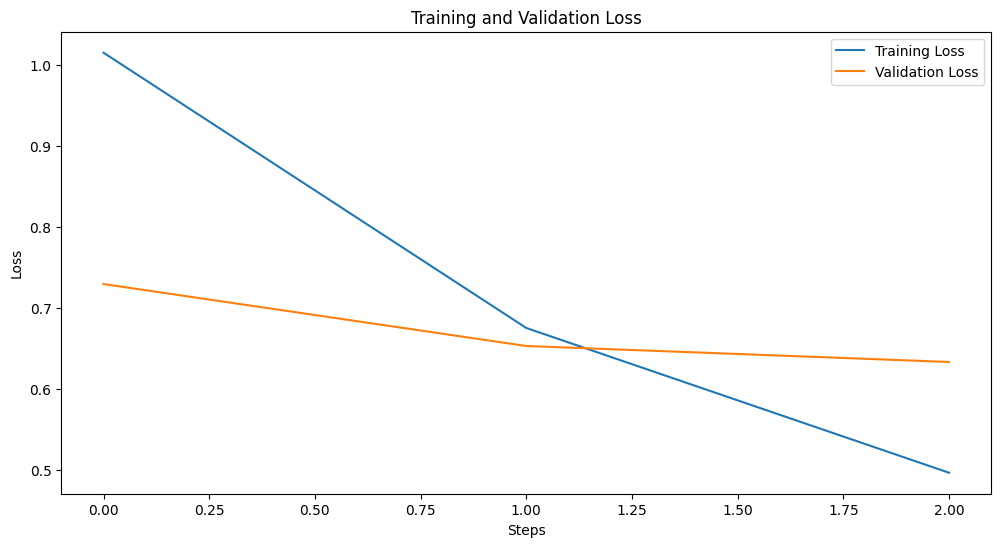

<Figure size 640x480 with 0 Axes>

In [22]:
# with open(f"{training_args.output_dir}/training.history", 'r') as f:
#     history = json.load(f)

# Access the logs and plot the training and validation curves
train_logs = trainer.state.log_history
train_losses = [log['loss'] for log in train_logs if 'loss' in log]
eval_losses = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]

# Plotting the curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.savefig("train_test_curves.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()